<a href="https://colab.research.google.com/github/jimbobfurly/electrodynamics-James-Kobelenz/blob/master/Final_Project_Diamond_Refraction_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project
By James Kobelenz

##Acknowledgements
Part of this code was implemented from Lab Notebook 7



```
`# This is formatted as code`
```

#Problem
diamond refraction/reflection

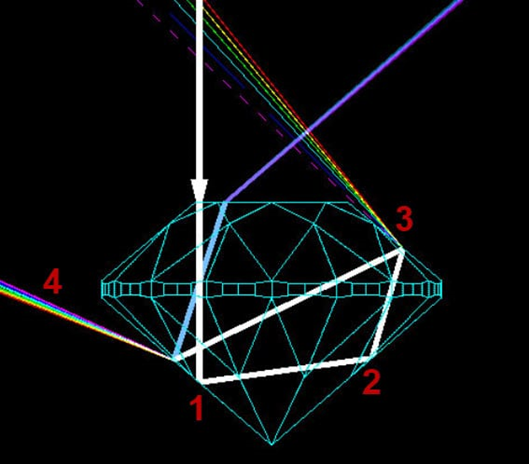

Image Source: https://www.igi.org/gemblog/cut-quality-cliffsnotes-for-diamonds/

##Diamond Dimensions and Proportions

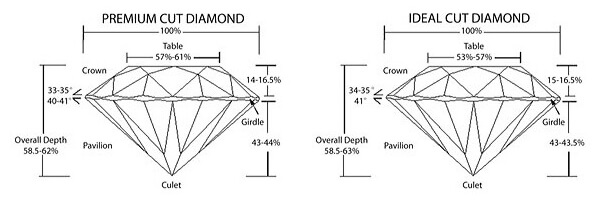
Image Source:https://www.b2cjewels.com/education/diamond-cut-guide

# Install and Load Packages

In [ ]:
from IPython import display

In [ ]:
try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh
    
    display.clear_output()

In [ ]:
try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

    display.clear_output()

In [ ]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

    display.clear_output()

In [ ]:
# Everything should be installed now.
# Import the rest of what we need.
import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

#Model


In [ ]:
## Parameters
# Diamond
diameter = 1 # 100%
table = 0.54*diameter # 54%
girdle = 0.034*diameter # 3.4%
depth = 0.593*diameter # 59.3%
crown_height = 0.15*diameter # 15%
pavillion_height = 0.43*diameter # 43%
# crown_angle = np.radians(34.5)
# pavillion_angle = np.radians(40.75)

# Diamond Index of refraction
nD = 2.3

# Background Index of Refraction (air)
nA = 1

# Background 
length = 2
width = 2

# Tell Gmsh how many dimensions we are using.
dim = 2

# Grid size parameter.  Make it smaller for higher resolution.
delta = 0.01

In [ ]:
# Locate the center.
x0 = 0
y0 = 0
z0 = 0

# Give inputs shorter nicknames.
L = length
W = width
h_crown = crown_height
h_pavillion = pavillion_height
# p_angle = pavillion_angle
# c_angle = crown_angle

# Create a new model.
gmsh.initialize()
gmsh.model.add("mesh")

# Create a rectangle for background.
background = gmsh.model.occ.addRectangle(-L/2, -W/2, 0, L, W)
gmsh.model.occ.synchronize()

# # Define diamond points:
d0 = gmsh.model.occ.addPoint(x0, y0-depth/2, z0, delta)
d1 = gmsh.model.occ.addPoint(x0-diameter/2, y0-depth/2+h_pavillion, z0, delta)
d2 = gmsh.model.occ.addPoint(x0-diameter/2, y0-depth/2+h_pavillion+girdle, z0, delta)
d3 = gmsh.model.occ.addPoint(x0-table/2, y0-depth/2+h_pavillion+girdle+h_crown, z0, delta)
d4 = gmsh.model.occ.addPoint(x0+table/2, y0-depth/2+h_pavillion+girdle+h_crown, z0, delta)
d5 = gmsh.model.occ.addPoint(x0+diameter/2, y0-depth/2+h_pavillion+girdle, z0, delta)
d6 = gmsh.model.occ.addPoint(x0+diameter/2, y0-depth/2+h_pavillion, z0, delta)

# Diamond points made with crown and pavillion angle; too shallow, might be problem with radians.
# d1 = gmsh.model.occ.addPoint(x1-diameter/2, y1-depth/2+diameter/2*np.sin(p_angle), z0, delta)
# d2 = gmsh.model.occ.addPoint(x1-diameter/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle, z0, delta)
# d3 = gmsh.model.occ.addPoint(x1-table/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle+(diameter-table)/2*np.sin(c_angle), z0, delta)
# d4 = gmsh.model.occ.addPoint(x1+table/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle+(diameter-table)/2*np.sin(c_angle), z0, delta)
# d5 = gmsh.model.occ.addPoint(x1+diameter/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle, z0, delta)
# d6 = gmsh.model.occ.addPoint(x1+diameter/2, y1-depth/2+diameter/2*np.sin(p_angle), z0, delta)

# # Define the perimeter of the diamond as a loop.
ld0 = gmsh.model.occ.addLine(d0, d1)
ld1 = gmsh.model.occ.addLine(d1, d2)
ld2 = gmsh.model.occ.addLine(d2, d3)
ld3 = gmsh.model.occ.addLine(d3, d4)
ld4 = gmsh.model.occ.addLine(d4, d5)
ld5 = gmsh.model.occ.addLine(d5, d6)
ld6 = gmsh.model.occ.addLine(d6, d0)
loop1 = gmsh.model.occ.addCurveLoop([ld0,ld1,ld2,ld3,ld4,ld5,ld6])


# Define the interior of the rectangle as a surface.
diamond = gmsh.model.occ.addPlaneSurface([loop1])

# Update the model with all of the features we add.
gmsh.model.occ.synchronize()

# Create beam of light (line)
# b0 = gmsh.model.occ.addPoint(x0-diameter/4, y0+5, z0, delta)
# b1 = gmsh.model.occ.addPoint(x0-diameter/2, y0+5, z0, delta)
# l0 = gmsh.model.occ.addLine(b0, b1)

# Update the model with all of the features we add.
gmsh.model.occ.synchronize()

# Resolve Boundaries
whole_domain = gmsh.model.occ.fragment([(2, background)],[(2, diamond)])
print(whole_domain[0])
# Update the model with all of the features we add.
gmsh.model.occ.synchronize()

# Create physical markers for each object.
# Use the following markers:
# - Vacuum: 0
# - Diamond: 1
# - Diamond walls: 2 - 8

background_surfaces = []
other_surfaces = []

for domain in whole_domain[0]:
    center = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
    mass = gmsh.model.occ.getMass(domain[0], domain[1])
    print(mass)
    print(center)
    #print(entities)
    # Identify the diamond by center of mass.
    if  np.isclose(mass, 0.3645):
        gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
        other_surfaces.append(domain)
        print(domain)
  
    # Identify the background rectangle by its center of mass
    else: # np.isclose(mass, ):
        background_surfaces.append(domain[1])
        print(domain)

# Add each edge separately, so it is a unique object.
# This will allow us to set the boundary conditions separately.
gmsh.model.addPhysicalGroup(1, [ld0], 2)
gmsh.model.addPhysicalGroup(1, [ld1], 3)
gmsh.model.addPhysicalGroup(1, [ld2], 4)
gmsh.model.addPhysicalGroup(1, [ld3], 5)
gmsh.model.addPhysicalGroup(1, [ld4], 6)
gmsh.model.addPhysicalGroup(1, [ld5], 7)
gmsh.model.addPhysicalGroup(1, [ld6], 8)

# gmsh.model.addPhysicalGroup(1, [l0], 9)


# Define the interior of the rectangle as our domain.
# gmsh.model.addPhysicalGroup(domain, (domain[1]), 2)

# Add marker for the vacuum.
gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)

# Create a mesh for this system.
gmsh.model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = dolfinx.io.gmshio.model_to_mesh(
    gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=2)

# Close the mesh generating program.
gmsh.finalize()

[(2, 2), (2, 3)]
0.3645000000000001
(-3.8073491928160364e-17, 0.08271353452217652, 0.0)
(2, 2)
3.6354999999999995
(3.053838604387723e-17, -0.008292967496447076, 0.0)
(2, 3)


In [ ]:
# Get separate identifiers for the four walls.
wall_2 = boundaries.indices[boundaries.values == 2]
wall_3 = boundaries.indices[boundaries.values == 3]
wall_4 = boundaries.indices[boundaries.values == 4]
wall_5 = boundaries.indices[boundaries.values == 5]
wall_6 = boundaries.indices[boundaries.values == 6]
wall_7 = boundaries.indices[boundaries.values == 7]
wall_8 = boundaries.indices[boundaries.values == 8]

beam_1 = boundaries.indices[boundaries.values == 9]

In [ ]:
# Plot the entire mesh.
multiphenicsx.io.plot_mesh(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# Plot the subdomains that FEniCSx has identified.
# There should only be one for this model.
multiphenicsx.io.plot_mesh_tags(subdomains)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# Change the last function argument to see the individual walls.
multiphenicsx.io.plot_mesh_entities(mesh, mesh.topology.dim - 1, wall_5)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

#Computation

In [ ]:
# Reflection coefficient


#Results


#Analysis


#Summary

#Extra code 
Code I didn't want to throw away yet 

In [ ]:
# Create a rectangle for background.
# Locate the center.
x0 = 0
y0 = 0
z0 = 0

# Give inputs shorter nicknames.
L = length
W = width
h_crown = crown_height
h_pavillion = pavillion_height
# p_angle = pavillion_angle
# c_angle = crown_angle


# Locate the corner.
x0 = x0 - L/2
y0 = y0 - W/2


# Create a new model.
gmsh.initialize()
gmsh.model.add("mesh")

# Define background points: corners of the rectangle.
p0 = gmsh.model.geo.addPoint(x0, y0, z0, delta)
p1 = gmsh.model.geo.addPoint(x0+L, y0, z0, delta)
p2 = gmsh.model.geo.addPoint(x0+L, y0+W,z0, delta)
p3 = gmsh.model.geo.addPoint(x0, y0+W, z0, delta)

# Define the perimeter of the rectangle as a loop.
l0 = gmsh.model.geo.addLine(p0, p1)
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p0)
loop0 = gmsh.model.geo.addCurveLoop([l0,l1,l2,l3])

# # New diamond center point
x1 = x0 + L/2
y1 = y0 + W/2

# # Define diamond points:
d0 = gmsh.model.geo.addPoint(x1, y1-depth/2, z0, delta)
d1 = gmsh.model.geo.addPoint(x1-diameter/2, y1-depth/2+h_pavillion, z0, delta)
d2 = gmsh.model.geo.addPoint(x1-diameter/2, y1-depth/2+h_pavillion+girdle, z0, delta)
d3 = gmsh.model.geo.addPoint(x1-table/2, y1-depth/2+h_pavillion+girdle+h_crown, z0, delta)
d4 = gmsh.model.geo.addPoint(x1+table/2, y1-depth/2+h_pavillion+girdle+h_crown, z0, delta)
d5 = gmsh.model.geo.addPoint(x1+diameter/2, y1-depth/2+h_pavillion+girdle, z0, delta)
d6 = gmsh.model.geo.addPoint(x1+diameter/2, y1-depth/2+h_pavillion, z0, delta)

# Diamond points made with crown and pavillion angle; too shallow, might be problem with radians.
# d1 = gmsh.model.geo.addPoint(x1-diameter/2, y1-depth/2+diameter/2*np.sin(p_angle), z0, delta)
# d2 = gmsh.model.geo.addPoint(x1-diameter/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle, z0, delta)
# d3 = gmsh.model.geo.addPoint(x1-table/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle+(diameter-table)/2*np.sin(c_angle), z0, delta)
# d4 = gmsh.model.geo.addPoint(x1+table/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle+(diameter-table)/2*np.sin(c_angle), z0, delta)
# d5 = gmsh.model.geo.addPoint(x1+diameter/2, y1-depth/2+diameter/2*np.sin(p_angle)+girdle, z0, delta)
# d6 = gmsh.model.geo.addPoint(x1+diameter/2, y1-depth/2+diameter/2*np.sin(p_angle), z0, delta)

# # Define the perimeter of the diamond as a loop.
ld0 = gmsh.model.geo.addLine(d0, d1)
ld1 = gmsh.model.geo.addLine(d1, d2)
ld2 = gmsh.model.geo.addLine(d2, d3)
ld3 = gmsh.model.geo.addLine(d3, d4)
ld4 = gmsh.model.geo.addLine(d4, d5)
ld5 = gmsh.model.geo.addLine(d5, d6)
ld6 = gmsh.model.geo.addLine(d6, d0)
loop1 = gmsh.model.geo.addCurveLoop([ld0,ld1,ld2,ld3,ld4,ld5,ld6])


# Define the interior of the rectangle as a surface.
rectangle = gmsh.model.geo.addPlaneSurface([loop0])
diamond = gmsh.model.geo.addPlaneSurface([loop1])

# Update the model with all of the features we add.
gmsh.model.geo.synchronize()

# Some geometric objects were only used to define others.
# Identify the physical objects.

# Add each edge separately, so it is a unique object.
# This will allow us to set the boundary conditions separately.
gmsh.model.addPhysicalGroup(1, [l0], 1)
gmsh.model.addPhysicalGroup(1, [l1], 2)
gmsh.model.addPhysicalGroup(1, [l2], 3)
gmsh.model.addPhysicalGroup(1, [l3], 4)

# Add each edge separately, so it is a unique object.
# This will allow us to set the boundary conditions separately.
gmsh.model.addPhysicalGroup(1, [ld0], 5)
gmsh.model.addPhysicalGroup(1, [ld1], 6)
gmsh.model.addPhysicalGroup(1, [ld2], 7)
gmsh.model.addPhysicalGroup(1, [ld3], 8)
gmsh.model.addPhysicalGroup(1, [ld3], 9)
gmsh.model.addPhysicalGroup(1, [ld3], 10)
gmsh.model.addPhysicalGroup(1, [ld3], 11)

# Define the interior of the rectangle as our domain.
gmsh.model.addPhysicalGroup(2, [rectangle], 1)
gmsh.model.addPhysicalGroup(2, [diamond], 2)
# BooleanFragments{ Surface{1,2}; Delete; }{}



# Create a mesh for this system.
gmsh.model.mesh.generate(dim)

# Bring the mesh into FEniCSx.
mesh, subdomains, boundaries = dolfinx.io.gmshio.model_to_mesh(
    gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=2)

# Close the mesh generating program.
gmsh.finalize()